# Managing Big Data for Connected Devices

## 420-N63-NA

## Kawser Wazed Nafi
 ----------------------------------------------------------------------------------------------------------------------------------

# Data Preprocessing and Selection of Features 
For example, we are going to use the following California Housing data set.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

#### Longitude
refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

#### Latitude 
refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

#### Housing Median Age
is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
#### Total Rooms
is the total number of rooms in the houses per block group

#### Total Bedrooms
is the total number of bedrooms in the houses per block group

#### Population
is the number of inhabitants of a block group

#### Households
refers to units of houses and their occupants per block group

#### Median Income
is used to register the median income of people that belong to a block group

#### Median House Value
is the dependent variable and refers to the median house value per block group

# Clustering Data

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data analysis, and a common technique for statistical data analysis, used in many fields, including pattern recognition, image analysis, information retrieval, bioinformatics, data compression, computer graphics and machine learning.

Cluster analysis itself is not one specific algorithm, but the general task to be solved. It can be achieved by various algorithms that differ significantly in their understanding of what constitutes a cluster and how to efficiently find them. Popular notions of clusters include groups with small distances between cluster members, dense areas of the data space, intervals or particular statistical distributions. Clustering can therefore be formulated as a multi-objective optimization problem. The appropriate clustering algorithm and parameter settings (including parameters such as the distance function to use, a density threshold or the number of expected clusters) depend on the individual data set and intended use of the results. Cluster analysis as such is not an automatic task, but an iterative process of knowledge discovery or interactive multi-objective optimization that involves trial and failure. It is often necessary to modify data preprocessing and model parameters until the result achieves the desired properties.

Besides the term clustering, there is a number of terms with similar meanings, including automatic classification, numerical taxonomy, botryology (from Greek βότρυς "grape"), typological analysis, and community detection. The subtle differences are often in the use of the results: while in data mining, the resulting groups are the matter of interest, in automatic classification the resulting discriminative power is of interest.

## K-means Clustering

k-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids.

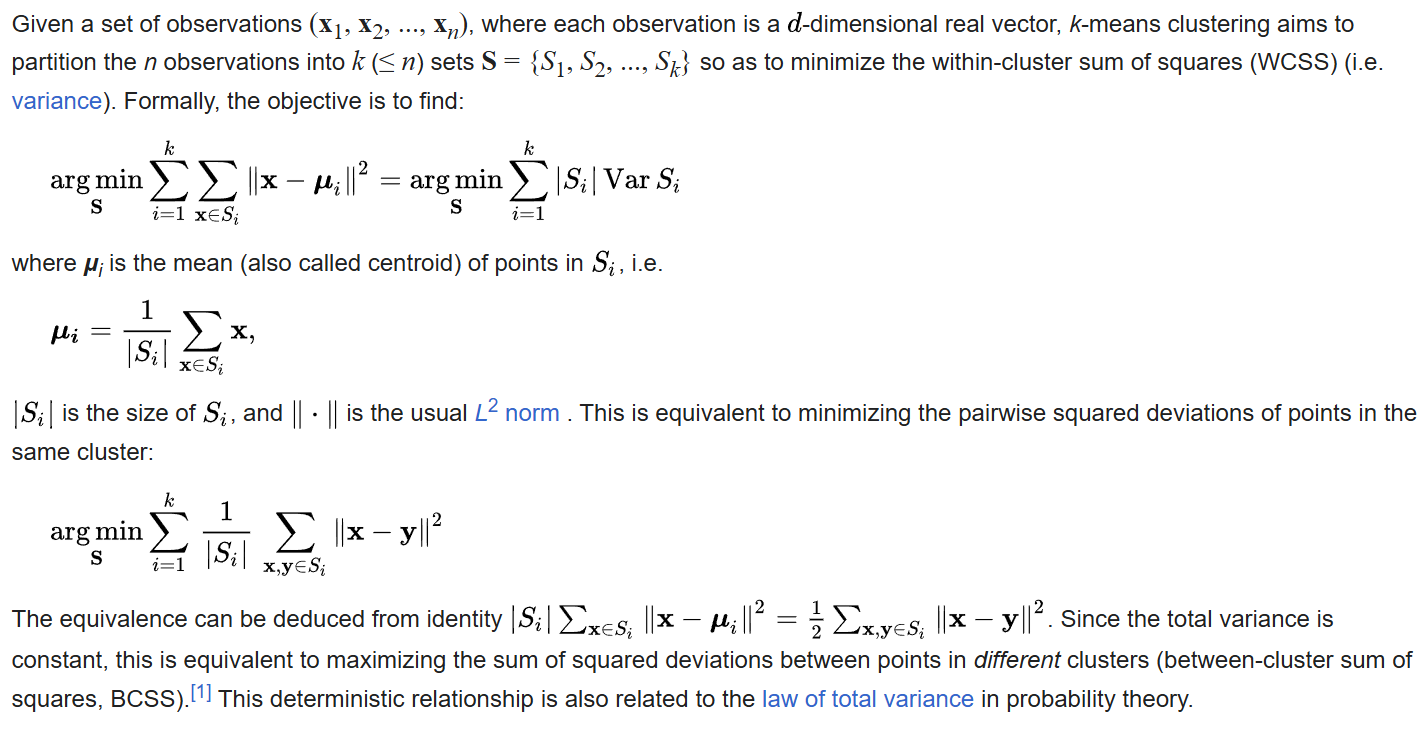




### Initialize the Spark Session and Importing the Libraries

In [46]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# show the schema of the dataframe
#housing_df.printSchema()

# run a sample selection
housing_df.select('pop','totbdrms').show(10)

# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

result_df.show(10)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



### Data Loading and Preprocessing

In [47]:
# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")
## Feature group normalization
'''In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '''
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when((col("medhv") <=1), 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1),1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2),2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3),3)
                                   .when((col("medhv") > 4),4))
housing_df.show(5)

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



'In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '

+-----+------+--------+------+--------+------+--------+--------+----------+------------+
|medhv|medage|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|medhvRounded|
+-----+------+--------+------+--------+------+--------+--------+----------+------------+
|4.526|  41.0|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|           4|
|3.585|  21.0|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|           3|
|3.521|  52.0|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|           3|
|3.413|  52.0|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|           3|
|3.422|  52.0|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|           3|
+-----+------+--------+------+--------+------+--------+--------+----------+------------+
only showing top 5 rows



### Feature Selection

In [48]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
# housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))
housing_df = housing_df.withColumn("label", col("medhvRounded").cast("double"))


# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")

from pyspark.ml.linalg import Vectors

# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])
transformed_df.show(5, truncate=False)

+-----+------+--------+------+--------+------+--------+--------+----------+------------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|medhv|medage|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|medhvRounded|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                                                                            

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 132.0 failed 1 times, most recent failure: Lost task 0.0 in stage 132.0 (TID 94) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


In [49]:
# Required Imports
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

# Spark Session Creation
ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load Data
HOUSING_DATA = 'input/cal_housing.data'

# Define Schema
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Adjust values of `medhv`
housing_df = housing_df.withColumn("medhv", col("medhv") / 100000)

# Add new feature columns
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms") / col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop") / col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms") / col("totrooms"), 2)))

# Reorder columns
housing_df = housing_df.select("medhv", "medage", "totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm")

# Create labels for classification
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when(col("medhv") <= 1, 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1), 1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2), 2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3), 3)
                                   .when(col("medhv") > 4, 4))

# Feature columns
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

# Ensure all feature columns are numeric (DoubleType)
from pyspark.sql.types import DoubleType
for col_name in featureCols:
    housing_df = housing_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Ensure label is also numeric
housing_df = housing_df.withColumn("label", col("medhvRounded").cast(DoubleType()))

# Fill null values with 0
housing_df = housing_df.fillna(0)

# Indexers for categorical features
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed") for c in featureCols]

# One-Hot Encoding for indexed features
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=f"{indexer.getOutputCol()}_encoded") for indexer in indexers]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders], outputCol="features")

# Define ML pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform the data
assembled_df = pipeline.fit(housing_df).transform(housing_df)

# Select finalized dataset
finalized_df = assembled_df.select("features", "label")

# Transform dataset using RDD mapping
transformed_df = finalized_df.rdd.map(lambda r: (Vectors.dense([float(c) for c in r[0]]), r[1])).toDF(["features", "label"])

# Show final transformed dataset
transformed_df.show(5, truncate=False)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 157.0 failed 1 times, most recent failure: Lost task 0.0 in stage 157.0 (TID 111) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


In [13]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, udf

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors

# Set display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

# Seaborn settings
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18, 4)})

# Set random seed for reproducibility
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

# Create Spark Session
ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'

# Define the schema
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.show(5)

# Show the dataframe columns
print(housing_df.columns)

# Show the schema of the dataframe
housing_df.printSchema()

# Adjust the values of `medhv`
housing_df = housing_df.withColumn("medhv", col("medhv") / 100000)

# Add new calculated columns
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms") / col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop") / col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms") / col("totrooms"), 2)))

# Re-order and select columns
housing_df = housing_df.select("medhv", "medage", "totbdrms", "pop", "houshlds", 
                               "medinc", "rmsperhh", "popperhh", "bdrmsperrm")

# **Feature Group Normalization** (Creating Target Classes)
housing_df = housing_df.withColumn("medhvRounded", 
                                   when(col("medhv") <= 1, 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1), 1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2), 2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3), 3)
                                   .otherwise(4))

housing_df.show(5)

# **Feature Engineering**
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

# Indexing feature columns (for categorical encoding)
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed") for c in featureCols]

# One-Hot Encoding
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=f"{indexer.getOutputCol()}_encoded") 
            for indexer in indexers]

# Use VectorAssembler to put all encoded features into a single feature column
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders], outputCol="features")

# Create a pipeline with all transformations
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Apply pipeline to the data
assembled_df = pipeline.fit(housing_df).transform(housing_df)

# Ensure `medhvRounded` is available as the label
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))

# Show transformed dataset
assembled_df.show(5, truncate=False)

# Select finalized features and labels
finalized_df = assembled_df.select("features", "label")
finalized_df.show(5)

# **Training Data Preparation**
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# Transform the dataset into a final model-ready format
transformed_df = vector_assembler.transform(housing_df).select("features", "medhvRounded")
transformed_df = transformed_df.withColumnRenamed("medhvRounded", "label")  # Rename target variable to label
transformed_df.show(5, truncate=False)

# **Train-Test Split**
train_df, test_df = transformed_df.randomSplit([0.8, 0.2], seed=42)

# **Model Training - Logistic Regression**
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1, elasticNetParam=0.8)

# Train the model
lr_model = lr.fit(train_df)

# **Model Evaluation**
predictions = lr_model.transform(test_df)

# Show predictions
predictions.select("label", "prediction").show(10)

# Evaluate model performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# Stop Spark session
ss.stop()

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows

['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv']
root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- ho

### Feature Indexing Creation for Better Mapping

In [14]:
# # Automatically identify categorical features, and index them.
# # We specify maxCategories so features with > 4 distinct values are treated as continuous.

# featureIndexer = VectorIndexer(inputCol="features", \
#                                outputCol="indexedFeatures",\
#                                maxCategories=4).fit(transformed_df)

# data = featureIndexer.transform(transformed_df)
# data.show(5, True)

from pyspark.ml.feature import VectorIndexer

# Apply VectorIndexer on the features column
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)

# Fit and transform the data
featureIndexerModel = featureIndexer.fit(transformed_df)
data = featureIndexerModel.transform(transformed_df)

# Show transformed data
data.show(5, truncate=False)


AssertionError: 

In [15]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, udf

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors

# Set display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

# Seaborn settings
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18, 4)})

# Set random seed for reproducibility
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

# **Step 1: Initialize Spark Session**
ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext  # Ensure SparkContext is available
sqlContext = SQLContext(sc)

# **Step 2: Load Data**
HOUSING_DATA = 'input/cal_housing.data'

# Define the schema
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.show(5)

# Show the dataframe schema
housing_df.printSchema()

# **Step 3: Data Preprocessing and Feature Engineering**
# Adjust the values of `medhv`
housing_df = housing_df.withColumn("medhv", col("medhv") / 100000)

# Add new calculated columns
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms") / col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop") / col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms") / col("totrooms"), 2)))

# Re-order and select columns
housing_df = housing_df.select("medhv", "medage", "totbdrms", "pop", "houshlds", 
                               "medinc", "rmsperhh", "popperhh", "bdrmsperrm")

# **Feature Group Normalization (Creating Target Classes)**
housing_df = housing_df.withColumn("medhvRounded", 
                                   when(col("medhv") <= 1, 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1), 1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2), 2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3), 3)
                                   .otherwise(4))

housing_df.show(5)

# **Step 4: Feature Engineering**
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# Transform the dataset
transformed_df = vector_assembler.transform(housing_df).select("features", "medhvRounded")
transformed_df = transformed_df.withColumnRenamed("medhvRounded", "label")  # Rename target variable

# Show transformed dataset
transformed_df.show(5, truncate=False)

# **Step 5: Apply VectorIndexer**
from pyspark.ml.feature import VectorIndexer

# Apply VectorIndexer on the features column
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)

# Fit and transform the data
featureIndexerModel = featureIndexer.fit(transformed_df)
indexed_df = featureIndexerModel.transform(transformed_df)

# Show transformed data
indexed_df.show(5, truncate=False)

# **Step 6: Train-Test Split**
train_df, test_df = indexed_df.randomSplit([0.8, 0.2], seed=42)

# **Step 7: Model Training - Logistic Regression**
lr = LogisticRegression(featuresCol="indexedFeatures", labelCol="label", maxIter=10, regParam=0.1, elasticNetParam=0.8)

# Train the model
lr_model = lr.fit(train_df)

# **Step 8: Model Evaluation**
predictions = lr_model.transform(test_df)

# Show predictions
predictions.select("label", "prediction").show(10)

# Evaluate model performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# **Step 9: Stop Spark Session**
ss.stop()

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (

### K-Means Model Creation & Training

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans(featuresCol="indexedFeatures", k=5)

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed_df)

cluster = model.transform(transformed_df)

cluster.show()

AssertionError: 

### Cluster Visualization

In [19]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=5, inputCol="features", outputCol="pca")
pca_model = pca.fit(transformed_df)
pca_transformed = pca_model.transform(transformed_df)

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

AssertionError: 

This step is done to create the cluster labels and group. The following steps will show the cluster visualization graph.

In [ ]:
cluster_assignment = np.array(cluster.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_class", "2nd_class","3rd_class", "4th_class", "5th_class","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, "1st_class", "2nd_class").add_legend()

plt.show()

### Cost Metric

We can use a metric for kmeans.
the K-means cost (sum of squared distances of points to their nearest center) for this model on the given data.

This metric can help us choose the number of clusters we want.

If we see a big gap between the distance of points to their nearest clusters then this should tell us something about the number of clusters in the data. 

In [37]:
cluster.select('features', 'prediction').show()

from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

clusteringCost = evaluator.evaluate(cluster)

clusteringCost

NameError: name 'cluster' is not defined

## Exercise 01
Could you please change the color of the clusters resulted from K-Means clustering output? Please check on them.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='pop', ylabel='medinc'>

Text(0.5, 1.0, 'K-Means Clustering with Custom Colors')

Text(0.5, 0, 'Population')

Text(0, 0.5, 'Median Income')

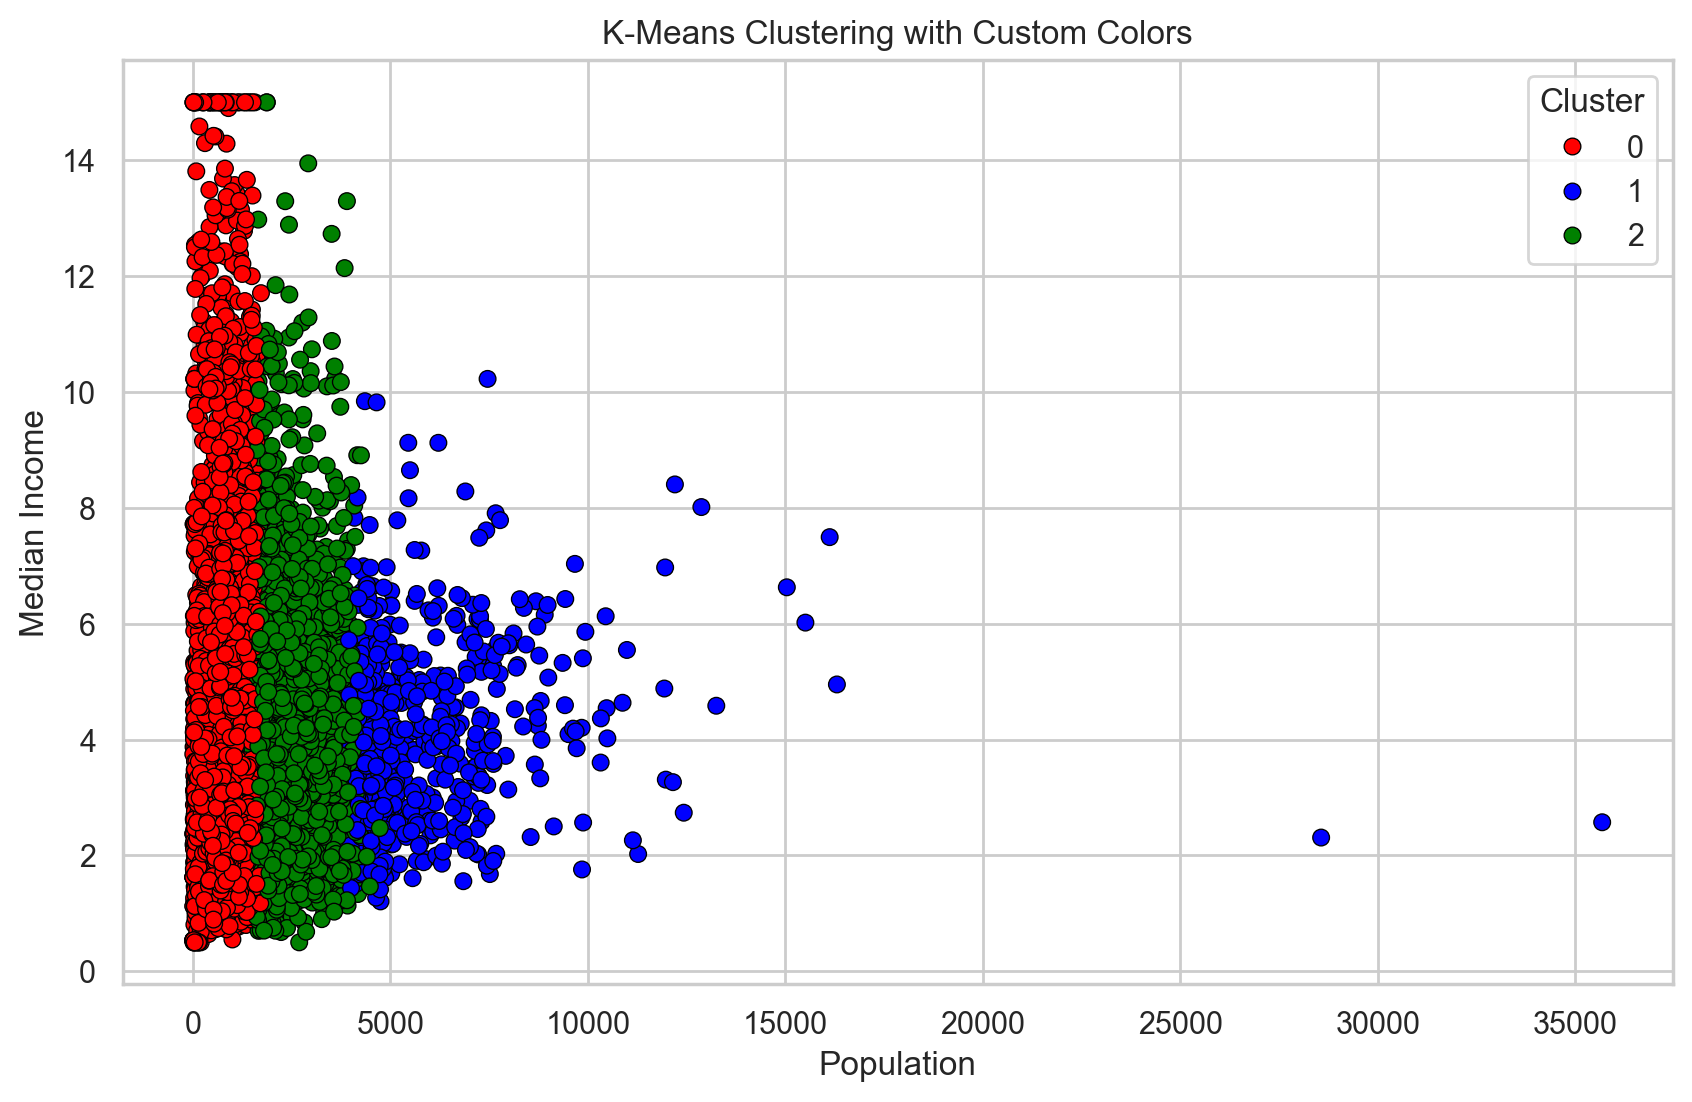

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# **Step 1: Prepare Feature Vector for K-Means**
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
vectorized_df = vector_assembler.transform(housing_df)

# **Step 2: Apply K-Means Clustering**
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)
model = kmeans.fit(vectorized_df)
clustered_df = model.transform(vectorized_df)

# **Step 3: Convert Spark DataFrame to Pandas for Visualization**
clustered_pd = clustered_df.select("pop", "medinc", "cluster").toPandas()

# **Step 4: Define Custom Cluster Colors**
custom_palette = {0: 'red', 1: 'blue', 2: 'green'}  # Modify as needed

# **Step 5: Visualize Clusters**
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_pd, x="pop", y="medinc", hue="cluster", palette=custom_palette, edgecolor="black")
plt.title("K-Means Clustering with Custom Colors")
plt.xlabel("Population")
plt.ylabel("Median Income")
plt.legend(title="Cluster")
plt.show()

In [36]:
from pyspark.ml.clustering import KMeans

# Define KMeans model
kmeans = KMeans(featuresCol="indexedFeatures", k=5)

# Fit KMeans on indexed data
model = kmeans.fit(indexed_df)

# Get cluster assignments
cluster = model.transform(indexed_df)

# Show clusters
cluster.show(5)


AssertionError: 

## Exercise 02
Can you divide the Median House Values (medhv) into 6 clusters based on the features available in dataset? Please visualize them properly.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='medinc', ylabel='medhv'>

Text(0.5, 1.0, 'K-Means Clustering of Median House Value (medhv)')

Text(0.5, 0, 'Median Income')

Text(0, 0.5, 'Median House Value')

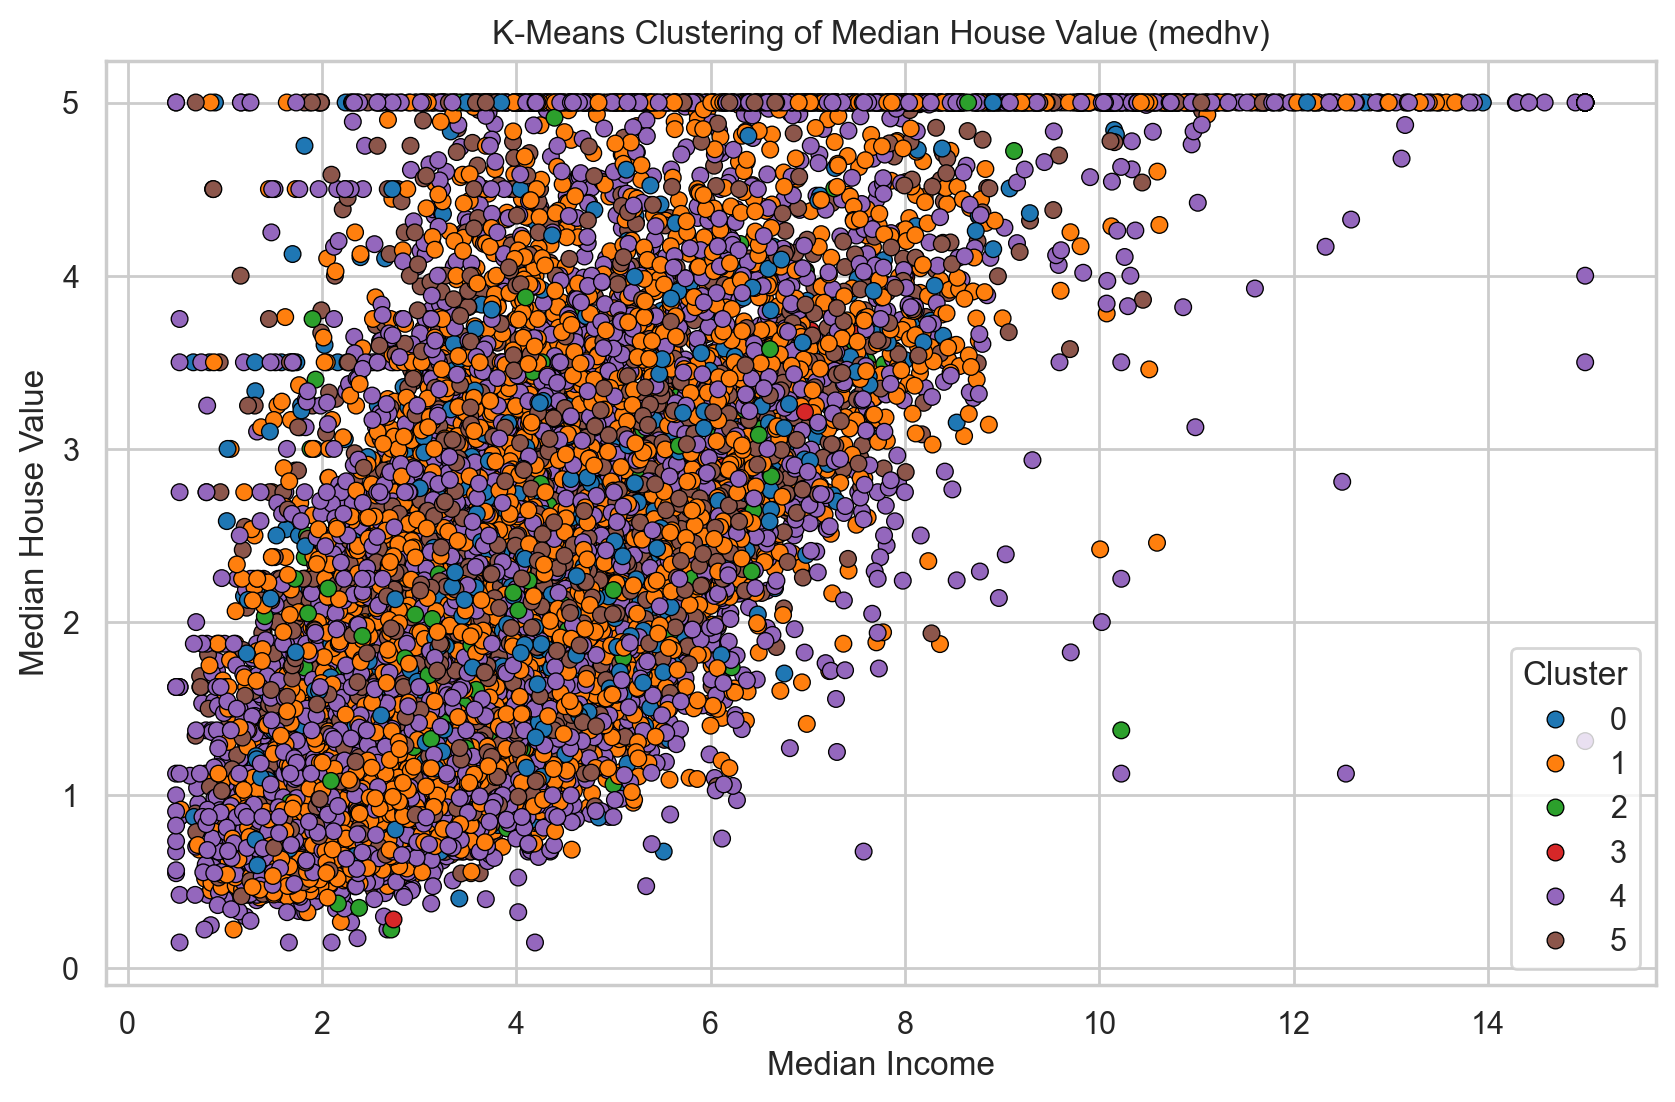

<Figure size 1000x500 with 0 Axes>

C:\Users\hiche\AppData\Local\Temp\ipykernel_17508\2794007609.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_pd, x="cluster", y="medhv", palette="pastel")


<Axes: xlabel='cluster', ylabel='medhv'>

Text(0.5, 1.0, 'Median House Value Distribution Across Clusters')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Median House Value')

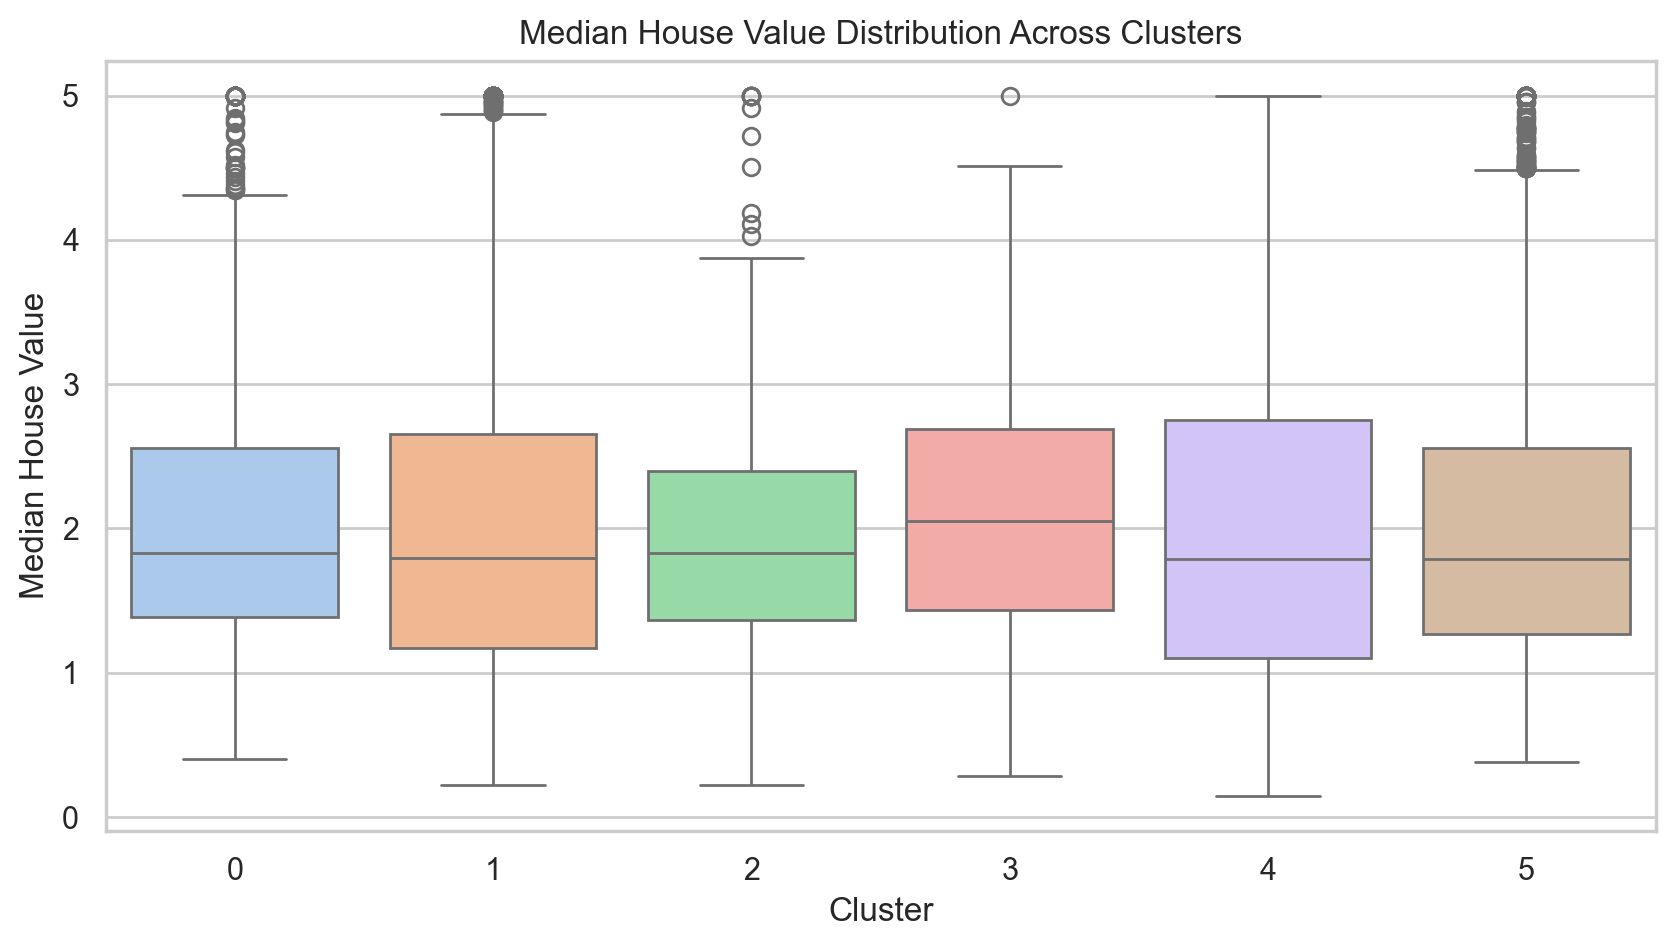

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# **Step 1: Feature Engineering**
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
vectorized_df = vector_assembler.transform(housing_df)

# **Step 2: Apply K-Means Clustering**
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=6, seed=42)
model = kmeans.fit(vectorized_df)
clustered_df = model.transform(vectorized_df)

# **Step 3: Convert Spark DataFrame to Pandas for Visualization**
clustered_pd = clustered_df.select("medhv", "medinc", "cluster").toPandas()

# **Step 4: Define Custom Colors for Clusters**
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.scatterplot(data=clustered_pd, x="medinc", y="medhv", hue="cluster", palette="tab10", edgecolor="black")

plt.title("K-Means Clustering of Median House Value (medhv)")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.legend(title="Cluster")
plt.show()

# **Optional: Box Plot for Cluster Distributions**
plt.figure(figsize=(10, 5))
sns.boxplot(data=clustered_pd, x="cluster", y="medhv", palette="pastel")
plt.title("Median House Value Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Median House Value")
plt.show()

## Exercise 03
You already have insurance.csv file with data for the last 3 assignments. Could you please create 4 clusters of people paying charges for this given dataset considering all the features available in the dataset? Please encode dataset values whenever required. Visualize the clusters you received after running K-means algorithm with the given dataset

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='bmi', ylabel='charges'>

Text(0.5, 1.0, 'K-Means Clustering of Insurance Charges')

Text(0.5, 0, 'BMI (Normalized)')

Text(0, 0.5, 'Charges (Normalized)')

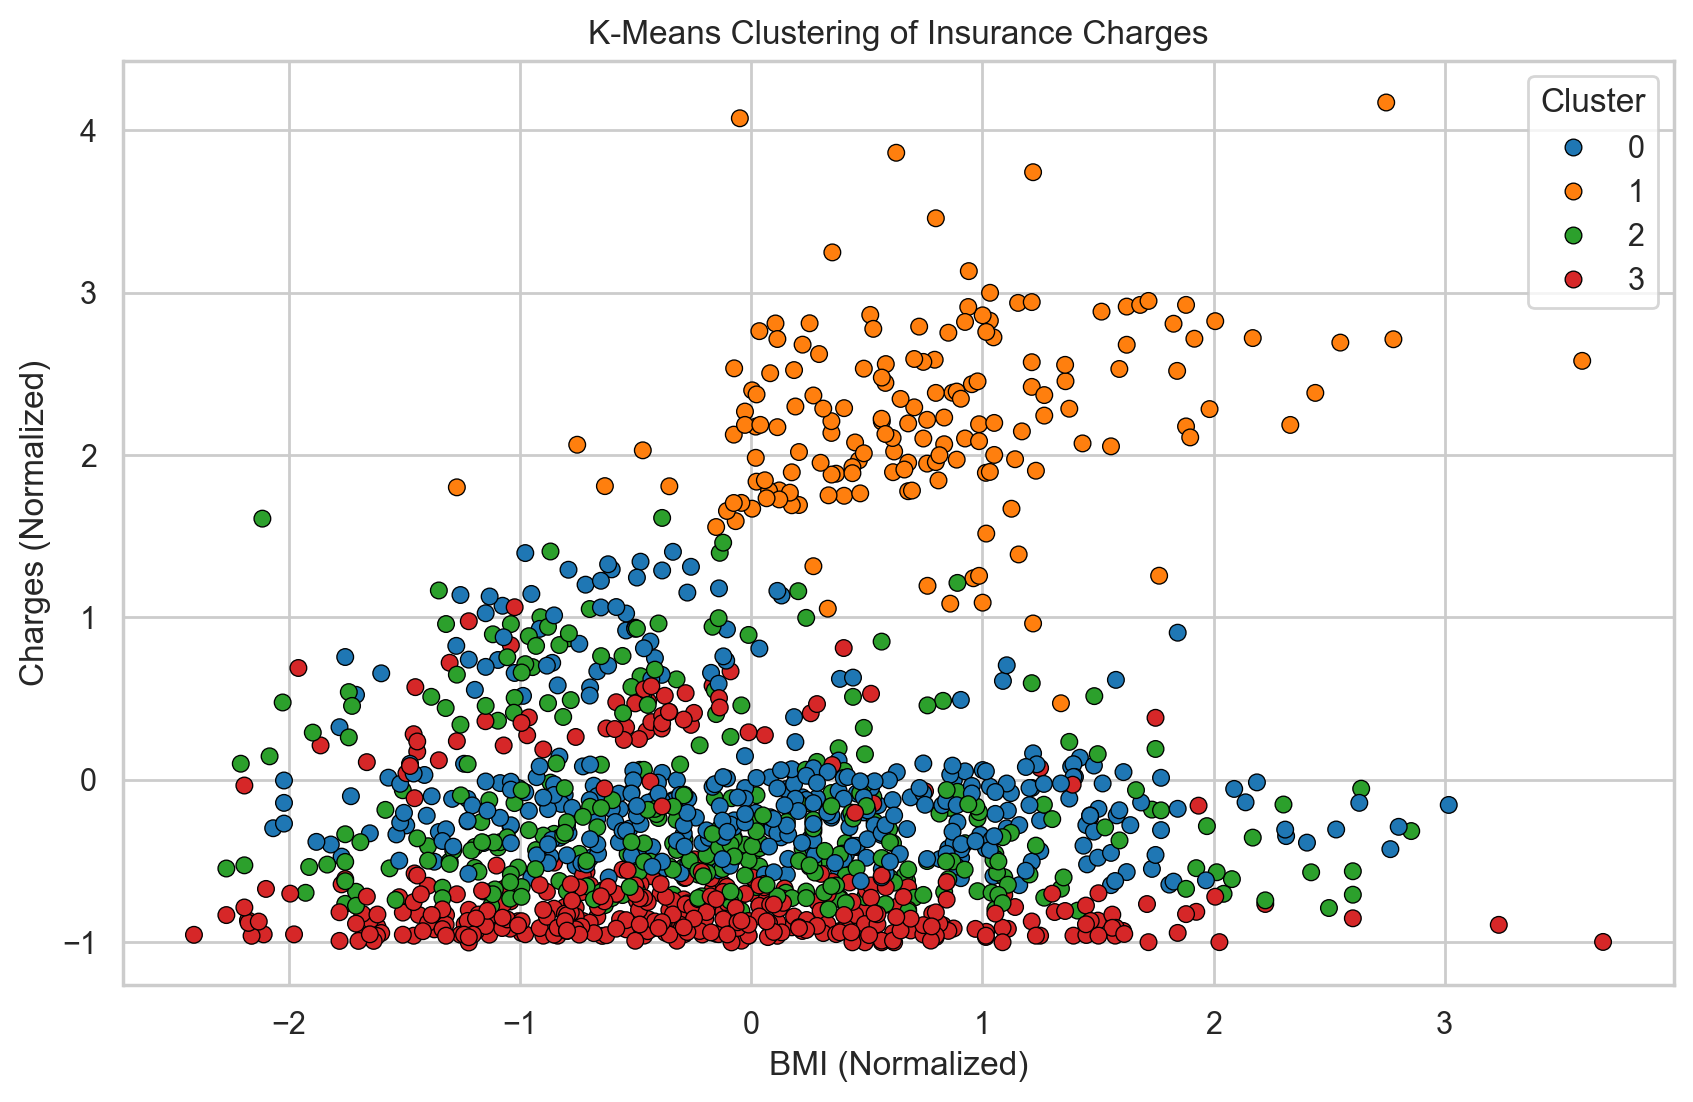

<Figure size 1000x500 with 0 Axes>

C:\Users\hiche\AppData\Local\Temp\ipykernel_17508\3444930982.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster", y="charges", palette="pastel")


<Axes: xlabel='cluster', ylabel='charges'>

Text(0.5, 1.0, 'Charge Distribution Across Clusters')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Charges (Normalized)')

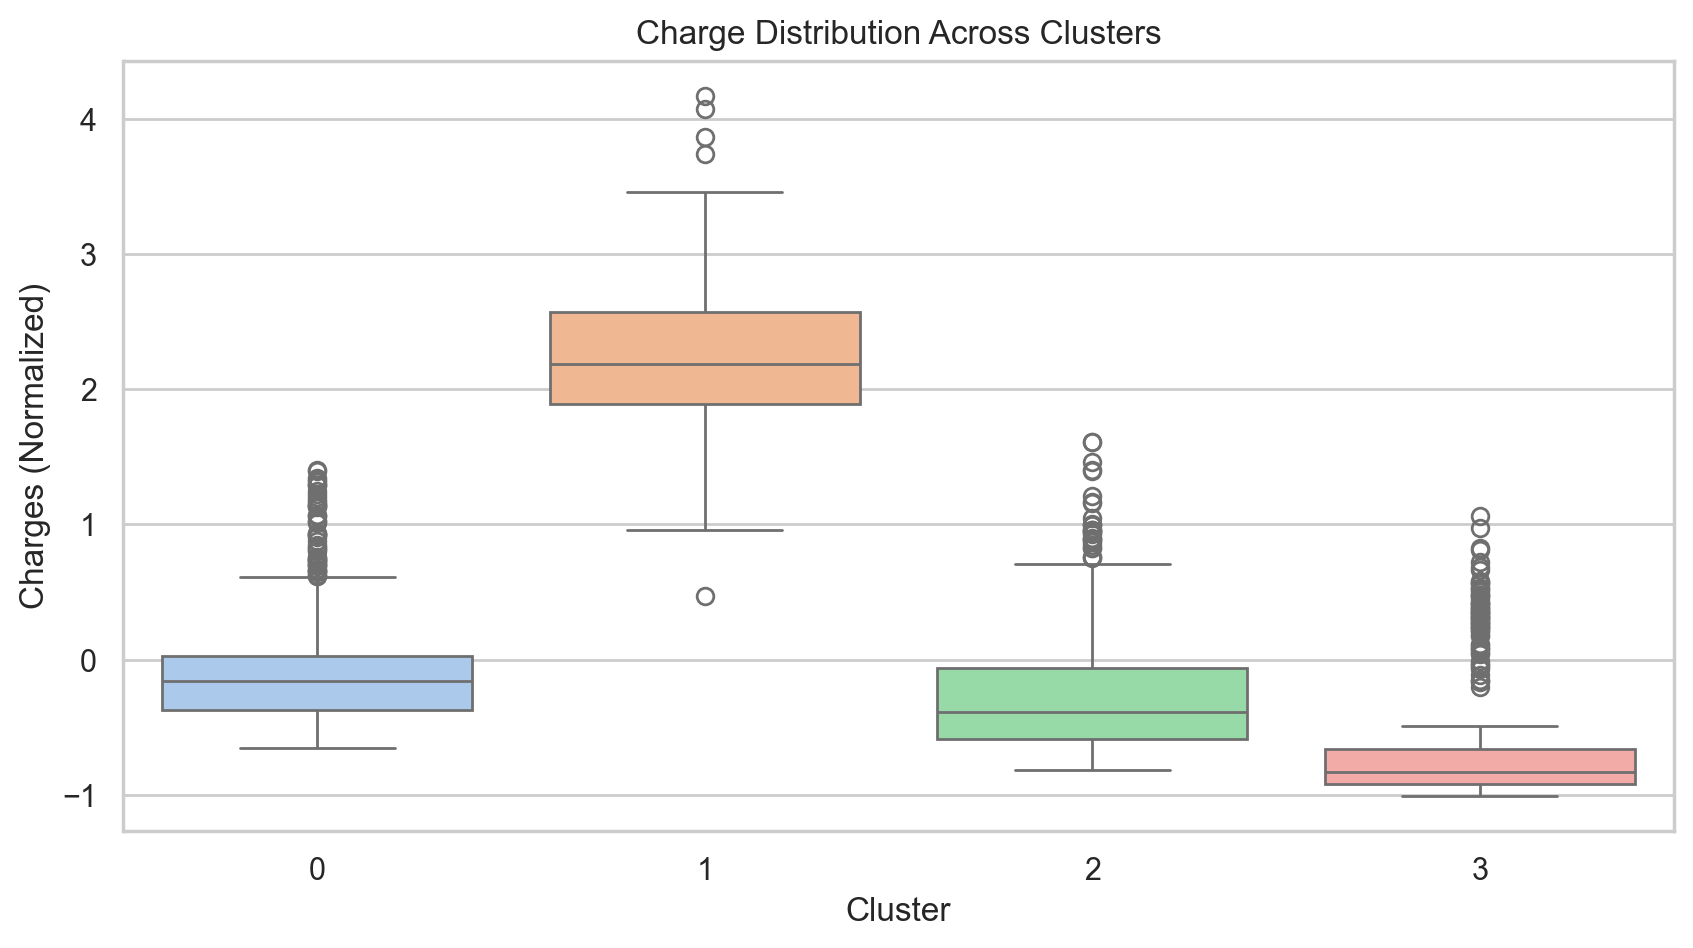

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# **Step 1: Load the Dataset**
df = pd.read_csv("insurance.csv")

# **Step 2: Encode Categorical Features**
label_encoders = {}
categorical_columns = ["sex", "smoker", "region"]

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for later use

# **Step 3: Normalize Numerical Features**
scaler = StandardScaler()
numerical_columns = ["age", "bmi", "children", "charges"]
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# **Step 4: Apply K-Means Clustering**
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(df[numerical_columns])

# **Step 5: Scatter Plot - Charges vs BMI**
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="bmi", y="charges", hue="cluster", palette="tab10", edgecolor="black")
plt.title("K-Means Clustering of Insurance Charges")
plt.xlabel("BMI (Normalized)")
plt.ylabel("Charges (Normalized)")
plt.legend(title="Cluster")
plt.show()

# **Step 6: Box Plot - Charges by Cluster**
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="cluster", y="charges", palette="pastel")
plt.title("Charge Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Charges (Normalized)")
plt.show()